In [1]:
import pandas as pd
import numpy as np
from eodhd import APIClient
import sys
sys.path.insert(0, "/Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src")
from Features import fundamental_features_new, fundamental_features, technical_features
import talib
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import sklearn
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import optuna
from optuna import Trial
import shap

In [2]:
zacks_fc = pd.read_csv("../data/fundamental_data/ZACKS_FC.csv", delimiter=',')
zacks_fc['per_end_date'] = pd.to_datetime(zacks_fc['per_end_date'])
zacks_fc['per_end_date'] = zacks_fc['per_end_date'].dt.tz_localize('US/Eastern')
zacks_fc['filing_date'] = pd.to_datetime(zacks_fc['filing_date'])
zacks_fc['filing_date'] = zacks_fc['filing_date'].dt.tz_localize('US/Eastern')
zacks_fc = zacks_fc.sort_values('per_end_date').set_index('per_end_date')

zacks_fr = pd.read_csv("../data/fundamental_data/ZACKS_FR.csv", delimiter=',')
zacks_fr['per_end_date'] = pd.to_datetime(zacks_fr['per_end_date'])
zacks_fr['per_end_date'] = zacks_fr['per_end_date'].dt.tz_localize('US/Eastern')
zacks_fr = zacks_fr.sort_values('per_end_date').set_index('per_end_date')

data = {
    "zacks_fc": zacks_fc,
    "zacks_fr": zacks_fr
}

C:\Users\manis\AppData\Local\Temp\ipykernel_26320\3539703636.py:1: DtypeWarning: Columns (4,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,44,45,46,47,49,50,51,52,53,54,55,56,57,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  zacks_fc = pd.read_csv("../data/fundamental_data/ZACKS_FC.csv", delimiter=',')
C:\Users\manis\AppData\Local\Temp\ipykernel_26320\3539703636.py:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  zacks_fr = pd.read_csv("../data/fundamental_data/ZACKS_FR.csv", delimiter=',')


In [3]:
tickers_df = pd.read_excel(r"C:/Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/data/sp1500_cleaned.xlsx")
tickers = tickers_df['ticker'].tolist()
len(tickers)

1506

In [4]:
combined_features = []
for ticker in tickers[:100]:
    data = {
    "zacks_fc": zacks_fc,
    "zacks_fr": zacks_fr
    }
    try:
        print(f"Processing ticker: {ticker}")
        obj = fundamental_features_new.BuildFeatures(data, ticker)
        obj.process_financial_statements()
        obj.extend_monthly()
        
        tech = technical_features.BuildFeatures(ticker)
        tech.build_technical_features()
        tech.technical_features.index = tech.technical_features.index.tz_convert('US/Eastern')

        df = pd.merge_asof(obj.fundamental_features, tech.technical_features, 
                           left_index=True, right_index=True, direction='nearest')

        obj.stock.sort_index(inplace=True)
        df = pd.merge_asof(df, obj.stock[['Close']],left_index=True, right_index=True, direction='backward')

        df.rename(columns={'Close': 'Close_Price'}, inplace=True)

        df['ticker'] = ticker  
        
        combined_features.append(df)
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

Processing ticker: VRSK


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\fundamental_features_new.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.fundamental_features.loc[:, "eps"].fillna(self.data['zacks_fc'].loc[:, "basic_net_eps"], inplace=True)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\fundamental_features_new.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future 

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing VRSK: Merge keys contain null values on left side
Processing ticker: EVTC


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing EVTC: Merge keys contain null values on left side
Processing ticker: AA


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing AA: Merge keys contain null values on left side
Processing ticker: PFG


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: NXPI


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing NXPI: Merge keys contain null values on left side
Processing ticker: CELH


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing CELH: Merge keys contain null values on left side
Processing ticker: AXP


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: VZ


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: BA


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing BA: Merge keys contain null values on left side
Processing ticker: RCL


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing RCL: Merge keys contain null values on left side
Processing ticker: DOW


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing DOW: Merge keys contain null values on left side
Processing ticker: CAT


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: SCVL


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: JPM


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing JPM: Merge keys contain null values on left side
Processing ticker: CVX


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: LII


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing LII: Merge keys contain null values on left side
Processing ticker: EME


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: KO


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: DIS


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: PSX


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing PSX: Merge keys contain null values on left side
Processing ticker: XOM


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: ALG


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: GE


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: HPQ


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: HD


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: IBM


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: DXCM


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: JNJ


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: MCD


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: MRK


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: MMM


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: BAC


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing BAC: Merge keys contain null values on left side
Processing ticker: PFE


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: PG


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: BKU


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing BKU: Merge keys contain null values on left side
Processing ticker: T


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: TRV


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: TKR


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: SBRA


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing SBRA: Merge keys contain null values on left side
Processing ticker: RTX


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing RTX: Merge keys contain null values on left side
Processing ticker: WMT


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: CSCO


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: PODD


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing PODD: Merge keys contain null values on left side
Processing ticker: INTC


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: MSFT


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: CYTK


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: KD


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing KD: Merge keys contain null values on left side
Processing ticker: AIN


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\fundamental_features_new.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.fundamental_features.loc[:, "eps"].fillna(self.data['zacks_fc'].loc[:, "basic_net_eps"], inplace=True)
c:\Users\manis\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `i

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: C


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing C: Merge keys contain null values on left side
Processing ticker: AIG


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: PEB


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing PEB: Merge keys contain null values on left side
Processing ticker: EYE


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing EYE: Merge keys contain null values on left side
Processing ticker: ATO


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: PI


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing PI: Merge keys contain null values on left side
Processing ticker: MO


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: GNRC


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing GNRC: Merge keys contain null values on left side
Processing ticker: BOH


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: STEP


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing STEP: Merge keys contain null values on left side
Processing ticker: SAIA


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: BKH


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: IIIN


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing IIIN: Merge keys contain null values on left side
Processing ticker: STX


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: LEA


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: WLK


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: VLTO


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing VLTO: Merge keys contain null values on left side
Processing ticker: MTRN


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: IP


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: KLG


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing KLG: Merge keys contain null values on left side
Processing ticker: TRNO


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\fundamental_features_new.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.fundamental_features.loc[:, "eps"].fillna(self.data['zacks_fc'].loc[:, "basic_net_eps"], inplace=True)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\fundamental_features_new.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future 

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing TRNO: Merge keys contain null values on left side
Processing ticker: CBT


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: CALX


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing CALX: Merge keys contain null values on left side
Processing ticker: CSL


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: ABT


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: CNH


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing CNH: Merge keys contain null values on left side
Processing ticker: AFL


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: APD


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: VC


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: CHTR


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: AM


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing AM: Merge keys contain null values on left side
Processing ticker: CHE


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: LBRT


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing LBRT: Merge keys contain null values on left side
Processing ticker: CCK


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: HES


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing HES: Merge keys contain null values on left side
Processing ticker: CMC


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: CTS


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: INSW


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing INSW: Merge keys contain null values on left side
Processing ticker: CW


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: APOG


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: BHF


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing BHF: Merge keys contain null values on left side
Processing ticker: DCI


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: CRSR


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing CRSR: Merge keys contain null values on left side
Processing ticker: ADM


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing ADM: Merge keys contain null values on left side
Processing ticker: DY


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing DY: Merge keys contain null values on left side
Processing ticker: ESE


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: ADP


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing ADP: Merge keys contain null values on left side
Processing ticker: LMAT


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing LMAT: Merge keys contain null values on left side
Processing ticker: AZO


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: FSS


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: AVY


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: FCF


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing FCF: Merge keys contain null values on left side


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

In [5]:
tech.technical_features

,SMA_50,SMA_200,Chaikin_ADI_Line,Chaikin_ADI_Oscillator,ADM_Index,ADM_Index_Rating,Absolute_Price_Oscillator,Average_True_Range,Average_Price,Bollinger_Band_Upper,...,Midpoint_Price_over_period,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Summation,Triple_Exponential_Moving_Average,Triple_Exponential_Moving_Average_Oscillator,True_Range,Close_Price
Date,,,,,,,,,,,,,,,,,,,,,
1992-06-10 00:00:00-04:00,NaN,NaN,27000.00000000,NaN,NaN,NaN,NaN,NaN,1.73860860,NaN,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,1.76807654
1992-06-11 00:00:00-04:00,NaN,NaN,23800.00000000,NaN,NaN,NaN,NaN,NaN,1.76580977,NaN,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,0.02720118,1.75900948
1992-06-12 00:00:00-04:00,NaN,NaN,30066.66666667,NaN,NaN,NaN,NaN,NaN,1.77034318,NaN,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,0.02720118,1.77714348
1992-06-15 00:00:00-04:00,NaN,NaN,30066.66666667,NaN,NaN,NaN,NaN,NaN,1.77714348,NaN,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,0.00000000,1.77714348
1992-06-16 00:00:00-04:00,NaN,NaN,7266.66666667,NaN,NaN,NaN,NaN,NaN,1.78167713,1.78346013,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,0.02720118,1.76807654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-26 00:00:00-05:00,16.63845123,16.09627951,54587720.39822271,-275077.10509615,8.77332465,12.05510703,-0.06775647,0.41390228,16.25000000,16.46046958,...,16.53977228,16.04000092,8234,16.99999809,8223,494.22495651,16.22682421,16.26311947,0.39999962,16.23999977
2025-02-27 00:00:00-05:00,16.60142124,16.10940933,54640735.64694888,-232275.88350558,8.33157025,11.43072890,-0.07633138,0.39933790,16.23999977,16.43367275,...,16.50000000,16.04000092,8234,16.90999985,8226,493.96131516,16.21079847,16.24749557,0.21000099,16.26000023
2025-02-28 00:00:00-05:00,16.56739578,16.12368366,55183935.64694888,-20813.93980893,8.21193757,11.09048240,-0.12029659,0.39152812,16.34500027,16.54247055,...,16.48000050,16.04000092,8234,16.90999985,8226,493.99676132,16.22841712,16.26750056,0.29000092,16.44000053


In [6]:
combined_features[0]

,total revenue,ebitda,eps,Dividend Payout Ratio,total_current_assets,,m_ticker,ticker,comp_name,comp_name_2,...,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Summation,Triple_Exponential_Moving_Average,Triple_Exponential_Moving_Average_Oscillator,True_Range,Close_Price,Close_Price
filing_date,,,,,,,,,,,,,,,,,,,,,
2006-04-30 20:00:00-04:00,2402.20000000,467.39980000,1.01000000,NaN,2281.80000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,27.79958344,1127,29.41032982,1135,853.96193504,29.20274020,29.08255837,0.47408338,28.97051239,29.30751038
2006-05-31 20:00:00-04:00,2402.20000000,467.39980000,1.01000000,NaN,2281.80000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,29.58740616,1150,31.21526527,1158,899.65676308,30.83992584,30.97544699,0.54261436,31.10103989,31.21526527
2006-06-30 20:00:00-04:00,2402.20000000,467.39980000,1.01000000,NaN,2281.80000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,29.88440704,1167,31.78645134,1180,918.72862244,30.96858071,30.99657638,0.53690333,31.78645134,31.78643799
2006-07-31 20:00:00-04:00,2459.80000000,386.50010000,0.76000000,NaN,1843.70000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,30.22141075,1201,31.01535225,1195,929.90097237,30.73985838,30.73127572,0.78823145,30.22141075,30.84400749
2006-08-31 20:00:00-04:00,2459.80000000,386.50010000,0.76000000,NaN,1843.70000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,30.22712708,1219,30.92967606,1213,915.88413620,30.34419019,30.26789967,0.15993115,30.32993126,30.40990257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 20:00:00-04:00,4053.30000000,627.09990000,2.22000000,NaN,28186.70000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,78.30554199,5687,82.94326782,5680,2400.03507996,79.21973707,80.09017438,1.06199761,79.93264008,79.93264771
2024-06-30 20:00:00-04:00,4310.80000000,443.89990000,1.49000000,NaN,28541.30000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,75.34288025,5699,79.44123077,5704,2356.53395844,78.14021978,77.13341729,1.45457491,76.66968536,77.10212708
2024-07-31 20:00:00-04:00,4310.80000000,443.89990000,1.49000000,NaN,28541.30000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,78.09477234,5731,85.95731354,5720,2415.68965149,80.27445288,81.68944813,2.58481046,78.09477234,80.10955048


In [7]:
final_df = pd.concat(combined_features)
final_df = final_df.sort_index()
print("Combined DataFrame shape:", final_df.shape)

# 5. Data preprocessing and handling missing values
print("Before processing missing values, final_df shape:", final_df.shape)
print("Missing values per column:")
print(final_df.isnull().sum())

# Use forward fill and backward fill to fill in missing values
final_df = final_df.ffill().bfill()
print("\nAfter forward fill and backward fill, final_df shape:", final_df.shape)
print("Missing values per column:")
print(final_df.isnull().sum())

# Drop columns that are entirely missing
final_df = final_df.dropna(axis=1, how='all')
print("\nAfter dropping columns with all missing values, final_df shape:", final_df.shape)
print("Missing values per column:")
print(final_df.isnull().sum())

Combined DataFrame shape: (13388, 171)
Before processing missing values, final_df shape: (13388, 171)
Missing values per column:
total revenue                                       0
ebitda                                            445
eps                                               127
Dividend Payout Ratio                           13388
total_current_assets                                0
                                                ...  
Triple_Exponential_Moving_Average                 145
Triple_Exponential_Moving_Average_Oscillator      154
True_Range                                        142
Close_Price                                         0
Close_Price                                       142
Length: 171, dtype: int64

After forward fill and backward fill, final_df shape: (13388, 171)
Missing values per column:
total revenue                                       0
ebitda                                              0
eps                                             

In [8]:
final_df.shape

(13388, 167)

In [9]:
final_df.head()

,total revenue,ebitda,eps,total_current_assets,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,...,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Summation,Triple_Exponential_Moving_Average,Triple_Exponential_Moving_Average_Oscillator,True_Range,Close_Price,Close_Price
filing_date,,,,,,,,,,,,,,,,,,,,,
2006-01-31 19:00:00-05:00,6628.00000000,1985.00000000,0.22000000,21611.00000000,CSCO,CSCO,Cisco Systems,"Cisco Systems, Inc.",NASDAQ,USD,...,12.03595924,4016,12.72524261,4010,362.47050285,12.34658984,12.51897399,0.17894903,12.31432343,12.30769062
2006-02-28 19:00:00-05:00,6628.00000000,1985.00000000,0.22000000,21611.00000000,CSCO,CSCO,Cisco Systems,"Cisco Systems, Inc.",NASDAQ,USD,...,12.95721054,4029,13.95799446,4042,381.08780479,13.32670900,13.47326993,0.58323861,13.95799446,13.41452599
2006-02-28 19:00:00-05:00,88327.00000000,7130.00000000,0.28670000,43825.00000000,WMS,WMT,Walmart,Walmart Inc.,NYSE,USD,...,10.13279533,8457,10.52329731,8448,308.00106049,10.22070399,10.19890534,0.10772397,10.13279533,10.17992306
2006-02-28 19:00:00-05:00,14997.00000000,2177.00000000,0.60000000,15269.00000000,HOMD,HD,Home Depot,"The Home Depot, Inc.",NYSE,USD,...,24.26694107,6155,26.46681023,6168,758.40856361,26.25698794,25.98855700,0.73950382,26.46681023,26.19337273
2006-02-28 19:00:00-05:00,1253.81500000,210.20700000,1.25000000,2034.99200000,AZO,AZO,AutoZone,"AutoZone, Inc.",NYSE,USD,...,96.68000031,3759,100.29000092,3760,2922.60001373,98.81171848,99.72316448,6.73000336,100.29000092,96.68000031


In [10]:
final_df.index = pd.to_datetime(final_df.index)
unique_dates = final_df.index.unique()
#target = pd.Timestamp('2006-04-30 19:00:00-05:00')
for date in unique_dates:
    filtered = final_df.loc[final_df.index == date]
    print(f"Date: {date}, Shape: {filtered.shape}")

Date: 2006-01-31 19:00:00-05:00, Shape: (1, 167)
Date: 2006-02-28 19:00:00-05:00, Shape: (6, 167)
Date: 2006-03-31 19:00:00-05:00, Shape: (20, 167)
Date: 2006-04-30 20:00:00-04:00, Shape: (60, 167)
Date: 2006-05-31 20:00:00-04:00, Shape: (60, 167)
Date: 2006-06-30 20:00:00-04:00, Shape: (60, 167)
Date: 2006-07-31 20:00:00-04:00, Shape: (60, 167)
Date: 2006-08-31 20:00:00-04:00, Shape: (60, 167)
Date: 2006-09-30 20:00:00-04:00, Shape: (60, 167)
Date: 2006-10-31 19:00:00-05:00, Shape: (60, 167)
Date: 2006-11-30 19:00:00-05:00, Shape: (60, 167)
Date: 2006-12-31 19:00:00-05:00, Shape: (60, 167)
Date: 2007-01-31 19:00:00-05:00, Shape: (60, 167)
Date: 2007-02-28 19:00:00-05:00, Shape: (60, 167)
Date: 2007-03-31 20:00:00-04:00, Shape: (60, 167)
Date: 2007-04-30 20:00:00-04:00, Shape: (61, 167)
Date: 2007-05-31 20:00:00-04:00, Shape: (60, 167)
Date: 2007-06-30 20:00:00-04:00, Shape: (60, 167)
Date: 2007-07-31 20:00:00-04:00, Shape: (60, 167)
Date: 2007-08-31 20:00:00-04:00, Shape: (60, 167)
Da

In [11]:
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

final_df['next_return'] = final_df['Close_Price'].shift(-1) / final_df['Close_Price'] - 1
final_df['next_return_median'] = final_df['Median_Price'].shift(-1) / final_df['Median_Price'] - 1
print(final_df.shape)

(13388, 168)


In [12]:
train_df = final_df['2006-01-31':'2019-01-01'].copy()
valid_df = final_df['2019-01-01': '2022-01-01'].copy()
test_df = final_df['2022-01-01':].copy()

In [13]:
train_df.shape

(9208, 168)

In [14]:
x_train = train_df.drop(['next_return', 'next_return_median'], axis=1)
y_train = train_df['next_return']
y_train_median = train_df['next_return_median']

x_valid = valid_df.drop(['next_return', 'next_return_median'], axis=1)
y_valid = valid_df['next_return']
y_valid_median = valid_df['next_return_median']

x_test = test_df.drop(['next_return', 'next_return_median'], axis=1)
y_test = test_df['next_return']
y_test_median = test_df['next_return_median']

In [15]:
# 1. Identify numeric and non-numeric columns in x_train
numeric_cols = x_train.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
non_numeric_cols = x_train.select_dtypes(exclude=['int64', 'float64', 'int32', 'float32']).columns

# 2. Initialize the scaler and scale the numeric columns
scaler = StandardScaler()
x_train_numeric_scaled = scaler.fit_transform(x_train[numeric_cols])
x_valid_numeric_scaled = scaler.transform(x_valid[numeric_cols])
x_test_numeric_scaled = scaler.transform(x_test[numeric_cols])

# 3. Convert the scaled numeric arrays back to DataFrames
x_train_numeric_scaled_df = pd.DataFrame(x_train_numeric_scaled, columns=numeric_cols, index=x_train.index)
x_valid_numeric_scaled_df = pd.DataFrame(x_valid_numeric_scaled, columns=numeric_cols, index=x_valid.index)
x_test_numeric_scaled_df = pd.DataFrame(x_test_numeric_scaled, columns=numeric_cols, index=x_test.index)

# Now x_train_final, x_valid_final, and x_test_final have the numeric features scaled and the string features intact.
rf = RandomForestRegressor(random_state=1)
rf.fit(x_train_numeric_scaled_df, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred = rf.predict(x_valid_numeric_scaled_df)
mse_valid = mean_squared_error(y_valid, y_valid_pred)
print("Validation MSE:", mse_valid)

Validation MSE: 18.176577345840776


In [16]:
# Using the model's built-in score method
r2_builtin = rf.score(x_valid_numeric_scaled_df, y_valid)
print("R^2 score (built-in):", r2_builtin)

# Alternatively, predict and then compute R² with r2_score:
y_valid_pred = rf.predict(x_valid_numeric_scaled_df)
r2 = r2_score(y_valid, y_valid_pred)
print("R^2 score:", r2)

R^2 score (built-in): 0.09595818272335188
R^2 score: 0.09595818272335188


In [17]:
def objective(trial: Trial, train=None, labels=None, val=None, val_labels=None):
    # Suggest hyperparameters
    rf_n_estimators = trial.suggest_int('n_estimators', 10, 100, step=5)
    rf_max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    rf_max_depth = trial.suggest_int('max_depth', 2, 10)
    
    rf_reg = RandomForestRegressor(
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        min_samples_leaf=rf_min_samples_leaf,
        max_features=rf_max_features,
        random_state=1
    )
    
    rf_reg.fit(train, labels)
    preds = rf_reg.predict(val)
    
    # Compute R-squared score
    r2 = r2_score(val_labels, preds)
    return r2

In [18]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, train=x_train_numeric_scaled_df, labels=y_train, val=x_valid_numeric_scaled_df, val_labels=y_valid), n_trials=400)

[I 2025-03-04 19:41:22,947] A new study created in memory with name: no-name-10203908-f403-4369-95c6-ddb458d179f3
[I 2025-03-04 19:41:24,085] Trial 0 finished with value: 0.036189020041375364 and parameters: {'n_estimators': 35, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'max_depth': 4}. Best is trial 0 with value: 0.036189020041375364.
[I 2025-03-04 19:41:26,856] Trial 1 finished with value: 0.08280183714483436 and parameters: {'n_estimators': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'max_depth': 8}. Best is trial 1 with value: 0.08280183714483436.
[I 2025-03-04 19:41:27,401] Trial 2 finished with value: 0.02976815097197749 and parameters: {'n_estimators': 30, 'max_features': 'log2', 'min_samples_leaf': 9, 'max_depth': 4}. Best is trial 1 with value: 0.08280183714483436.
[I 2025-03-04 19:41:29,443] Trial 3 finished with value: 0.02485824361550637 and parameters: {'n_estimators': 90, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'max_depth': 3}. Best is trial 1 with val

In [19]:
study.best_params

{'n_estimators': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'max_depth': 10}

In [20]:
rf = RandomForestRegressor(**study.best_params)

In [21]:
rf.fit(x_train_numeric_scaled_df, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred_op = rf.predict(x_valid_numeric_scaled_df)
mse_valid_op = mean_squared_error(y_valid, y_valid_pred_op)
print("Validation MSE:", mse_valid_op)

Validation MSE: 18.19055940556228


In [22]:
# predict and then compute R2 with r2_score:
y_valid_pred_op = rf.predict(x_valid_numeric_scaled_df)
r2 = r2_score(y_valid, y_valid_pred_op)
print("R^2 score:", r2)

ss_res = np.sum((y_valid - y_valid_pred_op) ** 2)
ss_tot = np.sum((y_valid - np.mean(y_valid)) ** 2)
#r2_manual = 1 - (ss_res / ss_tot)

#print("Manual R² score:", r2_manual)
print("SS total:", ss_tot)
print("SS residual:", ss_res)

R^2 score: 0.0952627621037605
SS total: 43428.75110057171
SS residual: 39291.60831601452


                       Feature  Importance
146               Median_Price  0.03164018
113              Parabolic_SAR  0.02666436
132              Typical_Price  0.02297585
43        Bollinger_Band_Upper  0.02276150
152  Highest_value_over_period  0.02157664
..                         ...         ...
84              Stick_Sandwich  0.00000000
87           Thrusting_Pattern  0.00000000
88             Tristar_Pattern  0.00000000
89              Unique_3_River  0.00000000
90        Upside_Gap_Two_Crows  0.00000000

[159 rows x 2 columns]


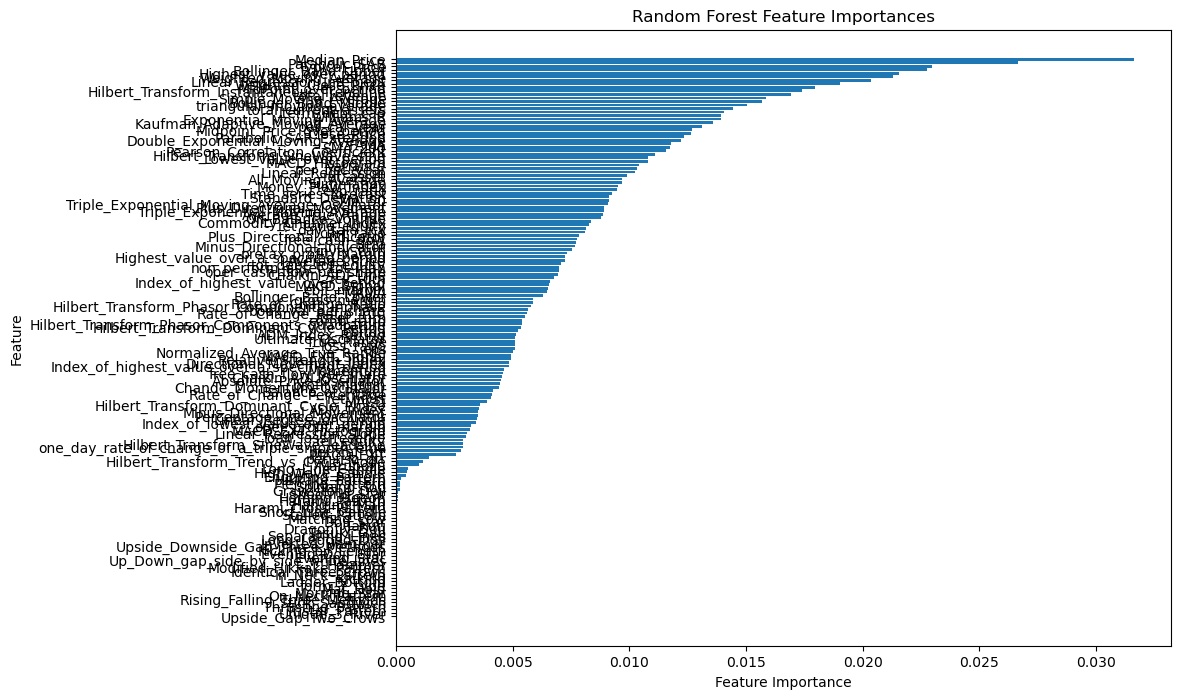

In [23]:
# Get feature importances from the model
importances = rf.feature_importances_

# Create a DataFrame for easier viewing and sorting
feature_importance_df = pd.DataFrame({
    'Feature': x_train_numeric_scaled_df.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features on top
plt.show()

In [24]:
features = feature_importance_df[feature_importance_df['Importance'] > 0.005]
features.shape

(84, 2)

In [25]:
features.head(15)

,Feature,Importance
146,Median_Price,0.03164018
113,Parabolic_SAR,0.02666436
132,Typical_Price,0.02297585
43,Bollinger_Band_Upper,0.02276150
152,Highest_value_over_period,0.02157664
137,Weighted_Moving_Average,0.02128150
108,Linear_Regression_Intercept,0.02033563
135,Weighted_Close_Price,0.01903849
148,MidPoint_over_period,0.01796204
103,Hilbert_Transform_Instantaneous_Trendline,0.01741791


In [26]:
x_train_red = x_train_numeric_scaled_df[features['Feature']]
x_valid_red = x_valid_numeric_scaled_df[features['Feature']]
x_test_red = x_test_numeric_scaled_df[features['Feature']]
x_train_red.shape

(9208, 84)

In [27]:
rf = RandomForestRegressor(random_state=1)
rf.fit(x_train_red, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred_red = rf.predict(x_valid_red)
mse_valid_red = mean_squared_error(y_valid, y_valid_pred_red)
print("Validation MSE:", mse_valid_red)

Validation MSE: 18.015349733427744


In [28]:
# predict and then compute R2 with r2_score:
y_valid_pred_red = rf.predict(x_valid_red)
r2 = r2_score(y_valid, y_valid_pred_red)
print("R^2 score:", r2)

ss_res = np.sum((y_valid - y_valid_pred_red) ** 2)
ss_tot = np.sum((y_valid - np.mean(y_valid)) ** 2)
#r2_manual = 1 - (ss_res / ss_tot)

#print("Manual R² score:", r2_manual)
print("SS total:", ss_tot)
print("SS residual:", ss_res)

R^2 score: 0.10397710184920184
SS total: 43428.75110057171
SS residual: 38913.15542420393
